# Cultural Data Science: Portfolio Assignment 3 

Daniel Lundgaard (202004134@post.au.dk)

1 December 2025

---

In [1]:
from matplotlib import (
    pyplot as plt, 
    ticker, 
    patheffects,
)
import re
import pandas as pd
import numpy as np
from scipy import stats
import warnings
import logging

plt.style.use("minimal.mplstyle")

warnings.filterwarnings("ignore", category = DeprecationWarning) 
logging.getLogger("matplotlib.font_manager").disabled = True

# The Data

We'll be looking at statistics on university admissions in the Kingdom of Denmark.

The data stems from [Den Koordinerede Tilmeldings Hovedtal](https://ufm.dk/uddannelse/statistik-og-analyser/sogning-og-optag-pa-videregaende-uddannelser/grundtal-om-sogning-og-optag/kot-hovedtal) (Main Facts and Figures on Admissions) hosted by the Uddannelses- og Forskningsministeriet (Department of Education and Research). 

First, we load in the raw data and parse it to get it into a convenient data structure.

Unfortunately, pre-2021 records are highly irregular and don't seem to adhere to any common schema.

As a result, we restrict ourselves to data covering the past four years: 2021-2024.

In [2]:
def parse_year(year):
    endpoint = "https://ufm.dk/uddannelse/statistik-og-analyser/sogning-og-optag-pa-videregaende-uddannelser/grundtal-om-sogning-og-optag/kot-hovedtal/" 
    filename = {
        2021: "hovedtal-2021",
        2022: "hovedtal-2022",
        2023: "kot-hovedtal-2023-excel",
        2024: "kot-hovedtal-2024",
    }[year]
    sheet = pd.read_excel(
        f"{endpoint}{filename}.xlsx",
        # f"data/KOT_{year}.xlsx", 
        sheet_name = 0,
        header = 0, 
        index_col = 0,
    )
    sheet = sheet.loc[:, (sheet.notna() & sheet != 0).any(axis=0)]

    sheet["Year"] = year
    colnames = ("ID", "Program", "AmountAdmitted", "AmountStandby", "AmountApplicants", "AmountTopPriority", "GPACutOff", "GPACutOffStandby", "Year")
    sheet.columns = colnames

    sheet = sheet.dropna(subset = "Program")
    sheet = sheet[~sheet["Program"].str.contains("i alt", case = False)]
    for col in ("GPACutOff", "GPACutOffStandby"):
        sheet[col] = pd.to_numeric(sheet[col].astype(str).apply(lambda val: pd.NA if " " in val else val.replace(",", ".")), errors = "coerce")
    sheet.reset_index(drop = True, inplace = True)

    institutions = sheet[sheet["ID"].isna()].reset_index()
    sheet = sheet[~sheet["ID"].isna()]
    for start, end, institution in zip(institutions["index"], institutions["index"].shift(-1).fillna(sheet.index[-1]).astype(int), institutions["Program"]):
        sheet.loc[start:end, "Institution"] = institution.strip()
    sheet["Institution"] = sheet["Institution"].str.replace(r"\([^)]*\)", "", regex = True)

    def parse_name(title, year):
        program, track, onset, location, online_only = None, None, None, None, False

        if "e-læring" in title.lower():
            online_only = True
            title = re.sub(",?-? ?e-læring", "", title, flags = re.IGNORECASE)

        if "Studieretning" in title:
            split = re.split(r", Studieretning: (.*), Studiestart: ", title) 
            onset = split.pop(-1) 
            track = split.pop(-1)
            title = split[0]
        split = re.split(r",\s*(?=[^)]*(?:\(|$))", title) 
        if not onset:
            onset = split.pop(-1)
        if split:
            location = split.pop(-1)
        program = ", ".join(split)
        program = program if program == program.upper() else program.title()
        return (program, track, onset, location, online_only)

    sheet[["Program", "Track", "Onset", "Location", "OnlineOnly"]] = sheet["Program"].apply(lambda row: parse_name(row, year)).values.tolist()
    sheet = sheet[["Program", "Institution", "Location", "Year", "AmountAdmitted", "AmountStandby", "AmountApplicants", "AmountTopPriority", "GPACutOff", "GPACutOffStandby", "OnlineOnly"]]
    cast_to_numeric_columns = ["AmountAdmitted", "AmountStandby", "AmountApplicants", "AmountTopPriority"]
    sheet[cast_to_numeric_columns] = sheet[cast_to_numeric_columns].apply(pd.to_numeric, errors="coerce")
    sheet["ApplicationsPerAdmission"] = sheet["AmountApplicants"] / sheet["AmountAdmitted"]

    return sheet

timespan_begin, timespan_end = 2021, 2024
admissions = pd.concat([parse_year(year) for year in range(timespan_begin, timespan_end + 1)], ignore_index = True)

admissions.info()
admissions.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Program                   3673 non-null   object 
 1   Institution               3673 non-null   object 
 2   Location                  3673 non-null   object 
 3   Year                      3673 non-null   int64  
 4   AmountAdmitted            3673 non-null   int64  
 5   AmountStandby             3050 non-null   float64
 6   AmountApplicants          3673 non-null   int64  
 7   AmountTopPriority         3673 non-null   int64  
 8   GPACutOff                 1366 non-null   float64
 9   GPACutOffStandby          675 non-null    float64
 10  OnlineOnly                3673 non-null   object 
 11  ApplicationsPerAdmission  3672 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 344.5+ KB


,Program,Institution,Location,Year,AmountAdmitted,AmountStandby,AmountApplicants,AmountTopPriority,GPACutOff,GPACutOffStandby,OnlineOnly,ApplicationsPerAdmission
389,Teknisk Videnskab (Civilingeniør) Energi,Aalborg Universitet,Esbjerg,2021,14,0.0,30,16,NaN,NaN,False,2.142857
2898,Fysik,Syddansk Universitet,Odense M,2024,33,0.0,93,34,NaN,NaN,False,2.818182
1189,Politik Og Økonomi,Aarhus Universitet,Aarhus C,2022,50,6.0,185,60,8.7,NaN,False,3.700000
895,Markedsføringsøkonom,Erhvervsakademi Dania,Randers SØ,2021,32,0.0,72,22,NaN,NaN,False,2.250000
987,"Business, Language And Culture",Copenhagen Business School - Handelshøjskolen,Frederiksberg,2022,135,NaN,521,191,7.3,NaN,False,3.859259
3438,Datamatiker,Professionshøjskolen University College Nordjy...,Aalborg SV,2024,93,0.0,190,98,NaN,NaN,False,2.043011
3533,"Professionsbachelor, Økonomi Og Informationste...",Zealand Sjællands Erhvervsakademi,Roskilde,2024,0,0.0,49,9,NaN,NaN,False,inf
2541,"Professionsbachelor, Maskinmester",Maskinmesterskolen København,Kalundborg,2023,0,0.0,9,3,NaN,NaN,False,inf
554,Financial Controller,UCL Erhvervsakademi og Professionshøjskole,Odense C,2021,28,0.0,81,31,NaN,NaN,False,2.892857
289,Economics And Business Administration,Aarhus Universitet,Aarhus C,2021,230,10.0,1065,437,8.2,7.7,False,4.630435


This gives us 3673 entries where each denotes a study program at an instituation and location in Denmark as well as the number of applications, number of applications where that program was the top-priority, the number of admissions (and standby spots offered), as well as the GPA cut-off delimiting those admitted from those not offered a place (iff there was such a cut-off).


# Looking Around

In [3]:
counts = admissions.groupby(["Year", "Institution"]).size().to_frame("Programs")
counts.sort_values(["Year", "Programs"], ascending=[True, False]).groupby("Year", as_index=False).nth[:5]

Programs
Year Institution                                          
2021 Aarhus Universitet                                 95
     Syddansk Universitet                               81
     Aalborg Universitet                                76
     Københavns Universitet                             73
     Professionshøjskolen VIA University College        67
2022 Aarhus Universitet                                 94
     Syddansk Universitet                               81
     Aalborg Universitet                                76
     Københavns Universitet                             73
     Professionshøjskolen VIA University College        63
2023 Aarhus Universitet                                 95
     Syddansk Universitet                               85
     Aalborg Universitet                                78
     Københavns Universitet                             74
     UCL Erhvervsakademi og Professionshøjskole         73
2024 Aarhus Universitet                                 93
     Syddansk Universitet                               79
     Aalborg Universitet                                76
     Københavns Universitet                             75
     UCL Erhvervsakademi og Professionshøjskole         67

Across the four years, Aarhus Universitet have offered the greatest number of unique programs, being the only one to offer more than 90.

In [4]:
counts = admissions.groupby(["Year", "Institution"])["AmountAdmitted"].sum().astype(int).to_frame("Students Admitted")
counts.sort_values(["Year", "Students Admitted"], ascending=[True, False]).groupby("Year", as_index=False).nth[:5]

Students Admitted
Year Institution                                                   
2021 Københavns Universitet                                    7674
     Aarhus Universitet                                        7243
     Professionshøjskolen VIA University College               6098
     Københavns Professionshøjskole                            5771
     Syddansk Universitet                                      4833
2022 Københavns Universitet                                    7175
     Aarhus Universitet                                        7113
     Københavns Professionshøjskole                            5174
     Professionshøjskolen VIA University College               5059
     Syddansk Universitet                                      4248
2023 Aarhus Universitet                                        7383
     Københavns Universitet                                    7204
     Professionshøjskolen VIA University College               5106
     Københavns Professionshøjskole                            5006
     Syddansk Universitet                                      4348
2024 Aarhus Universitet                                        7611
     Københavns Universitet                                    7230
     Professionshøjskolen VIA University College               5109
     Københavns Professionshøjskole                            4742
     Syddansk Universitet                                      4355

Aarhus Universitet also overtook Københavns Universitet in 2023 to become the university enrolling the greatest number of students in Denmark. 

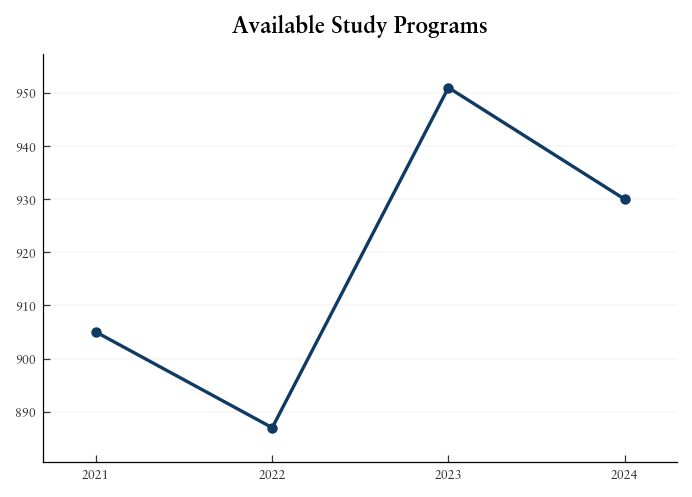

In [5]:
years = sorted(admissions["Year"].unique())

available_programs_per_year = admissions.groupby("Year").size()
plt.figure()
plt.plot(available_programs_per_year, marker = "o")
# plt.xticks(years, ["'" + str(year)[2:] for year in years])
plt.xticks(years, years)
plt.title("Available Study Programs")
# plt.ylim(0, 1000)
plt.margins(x = 0.1, y = 0.1)
plt.show()

The number of programs of offered programs is on the order of 900, rising to more than 950 in 2023 before decreasing to 930 in 2024. 

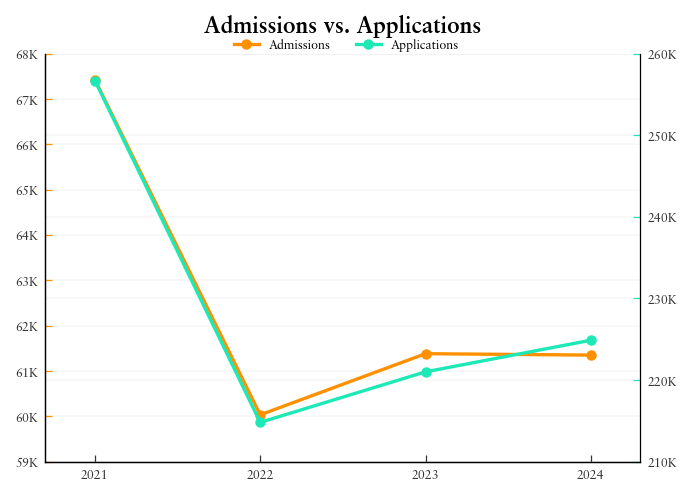

In [6]:
fig, ax = plt.subplots()
available_placements_per_year = admissions.groupby("Year")["AmountAdmitted"].sum()

ax.plot(available_placements_per_year, marker = "o", color = "C1", label = "Admissions")
# ax.xticks(years, ["'" + str(year)[2:] for year in years])
ax.set_xticks(years)
ax.tick_params(axis = "y", color = "C1")
ax.set_yticks(ax.get_yticks(), [str(round(val / 1000)) + "K" for val in ax.get_yticks()])

ax2 = ax.twinx()
available_applications_per_year = admissions.groupby("Year")["AmountApplicants"].sum()

ax2.margins(x = 0.1)
ax2.plot(available_applications_per_year, marker = "o", color = "C2", label = "Applications")
ax2.set_yticks(ax2.get_yticks(), [str(round(val / 1000)) + "K" for val in ax2.get_yticks()])
ax2.tick_params(color = "C2")
ax2.spines["right"].set_visible(True)
ax2.set_title("Admissions vs. Applications")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, 0.96), ncol = 2)
plt.show()

Over the past four years, the number of students admitted has dropped from more than 67 thousand down to under 62 thousand.

The ratio between amount of applications received and positions offered has been relatively stable, suppy seeming to follow demand at least at a macro level.

We can take a look at what has happened to the sizes of study programs, i.e. the amount of students admitted to a program in 2024 vs. the amount of students admitted in 2024:

In [7]:
def handler(group):
    group["AmountApplicants"] = group["AmountApplicants"].fillna(0)
    group["AmountApplicants"] = group.groupby("Year")["AmountApplicants"].transform("sum")
    group = group.drop_duplicates(subset = ["Program", "Location", "Year"], keep = "first")
    group["YearsSinceLaunch"] = group["Year"] - group["Year"].min()
    group["Index"] = group["AmountApplicants"] / group[group["YearsSinceLaunch"] == 0].iloc[0]["AmountApplicants"]
    group["PrevYearAmountApplicants"] = group["AmountApplicants"].shift()
    group["YoY"] = group["AmountApplicants"] / group["PrevYearAmountApplicants"]
    group = group.iloc[1:]
    return group

admissions["Index"] = 0
admissions["PrevYearAmountApplicants"] = 0
admissions["YearsSinceLaunch"] = 0

size_changes = admissions.groupby(["Program", "Institution", "Location"], group_keys=False).apply(handler)[["Program", "Institution", "Location", "Year", "YearsSinceLaunch", "AmountApplicants", "PrevYearAmountApplicants", "Index", "YoY"]]
size_changes["Change"] = size_changes["Index"].apply(lambda val: f"{val - 1:+.0%}")
size_changes["YoY Change"] = size_changes["YoY"].apply(lambda val: f"{val - 1:+.0%}")

size_changes.sort_values("Index", ascending = False)

,Program,Institution,Location,Year,YearsSinceLaunch,AmountApplicants,PrevYearAmountApplicants,Index,YoY,Change,YoY Change
2732,"Installatør, Vvs",Erhvervsakademi Dania,Randers SØ,2023,1,5,0.0,inf,inf,+inf%,+inf%
2963,Bachelor Of Engineering In Mechanical Engineering,Syddansk Universitet,Sønderborg,2024,3,467,321.0,4.207207,1.454829,+321%,+45%
3583,"Professionsbachelor, Finans",Erhvervsakademi SydVest,Esbjerg,2024,2,196,139.0,4.170213,1.410072,+317%,+41%
3500,Markedsføringsøkonom,Erhvervsakademiet Copenhagen Business Academy,Hillerød,2024,3,314,106.0,3.738095,2.962264,+274%,+196%
2957,Bachelor Of Science (Bsc) In Engineering (Engi...,Syddansk Universitet,Sønderborg,2024,3,436,387.0,3.114286,1.126615,+211%,+13%
...,...,...,...,...,...,...,...,...,...,...,...
3441,Energiteknolog,Professionshøjskolen University College Nordjy...,Aalborg SV,2024,3,8,19.0,0.333333,0.421053,-67%,-58%
3199,"Professionsbachelor, Ernæring Og Sundhed",Professionshøjskolen Absalon,Slagelse,2024,3,64,79.0,0.326531,0.810127,-67%,-19%
1966,International Virksomhedskommunikation I 2 Fre...,Syddansk Universitet,Odense M,2023,2,16,36.0,0.307692,0.444444,-69%,-56%
3293,"Professionsbachelor, Pædagog",UCL Erhvervsakademi og Professionshøjskole,Svendborg,2024,3,65,84.0,0.270833,0.773810,-73%,-23%


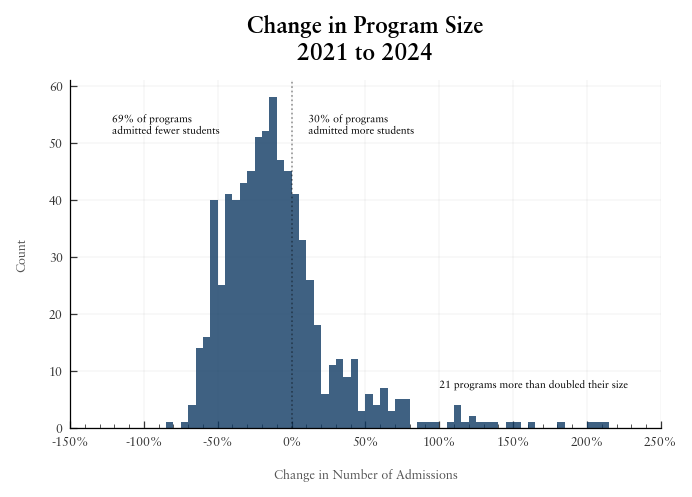

In [8]:
values = size_changes[size_changes["Year"] == 2024]["Index"] - 1
ax = values.hist(bins = np.arange(-1.5, 2.5, 0.05), alpha = 0.8)
ax.set_xticks(ax.get_xticks(), [f"{tick:.0%}" for tick in ax.get_xticks()])
plt.title("Change in Program Size\n2021 to 2024")
plt.xlabel("Change in Number of Admissions")
plt.ylabel("Count")
plt.axvline(0, color = "black", alpha = 0.4, linewidth = 0.8, linestyle = ":")
plt.gca().xaxis.minorticks_on()
plt.annotate(
    f"{(values > 0).mean():.0%} of programs\nadmitted more students", 
    (0, 55), 
    xytext=(8, 0),
    textcoords = "offset points", 
    size = 5,
    va = "top",
    ha = "left",
).set_path_effects([patheffects.Stroke(linewidth=1, foreground="white"), patheffects.Normal()])

plt.annotate(
    f"{(values > 1).sum():.0f} programs more than doubled their size", 
    (1, 7), 
    size = 5,
    ha = "left",
).set_path_effects([patheffects.Stroke(linewidth=1, foreground="white"), patheffects.Normal()])

plt.annotate(
    f"{(values < 0).mean():.0%} of programs\nadmitted fewer students", 
    (-1.3, 55), 
    xytext=(6, 0),
    textcoords = "offset points", 
    size = 5,
    va = "top",
    ha = "left",
).set_path_effects([patheffects.Stroke(linewidth=1, foreground="white"), patheffects.Normal()])

plt.show()

Roughly a third increased in size to admit more students, while the remaining two thirds diminsed in size. More than 20 programs doubled the number of students admitted over the three years from 2021 to 2024.

# Actual Analysis

What we'll be looking at is the relationship between the ratio of applications to admissions (what we'll call "scarcity") and the GPA cut-off. 

This, of course, only applies to study program where not all applicants were accepted, in which cases the GPA cut-off denotes the lowest GPA to get admitted (of the students applying using their GPA, as opposed to those applying through alternative criteria, e.g. quota 2).

In [9]:
print(f"""{admissions["GPACutOff"].isna().mean():.1%} of programs rejected some applicants and thus had a GPA cut-off""")
print(f"""The lowest GPA cut-off was {admissions["GPACutOff"].min():.1f} while the program requiring the highest GPA had a cut-off of {admissions["GPACutOff"].max():.1f}""")

62.8% of programs rejected some applicants and thus had a GPA cut-off
The lowest GPA cut-off was 2.0 while the program requiring the highest GPA had a cut-off of 11.7


In [10]:
scarce_programs = admissions[~admissions["GPACutOff"].isna()]

Because a linear regression model assumes independence of datapoints, and the admissions data is inherently a time series, we'll have to model the relationship within each year separately. We'll look at the relationship for 2024.

In [11]:
scarce_programs_2024 = scarce_programs[scarce_programs["Year"] == 2024]
subset = scarce_programs_2024

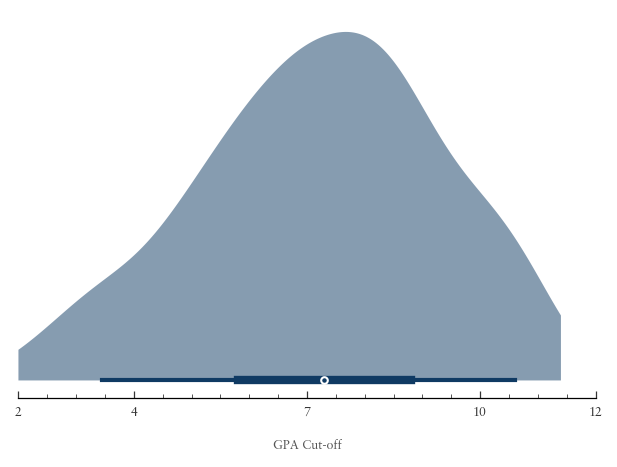

In [12]:
def plot_dist(data, title, clamp_range = False, *args, **kwargs):
    data = data.dropna()
    x_range = np.linspace(*data.agg(("min", "max")), num = 1000)
    if clamp_range:
        x_range = np.linspace(*data.quantile((0, 0.99)), num = 1000)
    estimation = stats.gaussian_kde(data)(x_range)

    plt.figure(figsize = (4, 3))
    plt.fill_between(
        x_range, 
        estimation,
        color = "C0",
        alpha = 0.5,
        edgecolor = "none",
    )

    for interval, linewidth in zip((0.5, 0.9), (4, 2)):
        plt.plot(
            np.quantile(data, ((1 - interval) / 2, 1 - (1 - interval) / 2)),
            [0, 0],
            linewidth = linewidth,
            color = "C0",
        )
    plt.scatter(
        [np.median(data)],
        [0],
        facecolor = "C0",
        edgecolor = "white",
        marker = "o",
        s = 10,
        zorder = 2,
    )
    plt.yticks([])
    plt.gca().spines["left"].set_visible(False)
    plt.gca().minorticks_on()
    plt.xlabel(title)

plot_dist(subset["GPACutOff"], title = "GPA Cut-off")
plt.xticks((2, 4, 7, 10, 12))
plt.show()

The outcome variable, GPA Cut-off, seems to loosely resemble a gaussian distribution (or at least a high-kurtosis t-distribution) which will be sufficient for our purposes. 

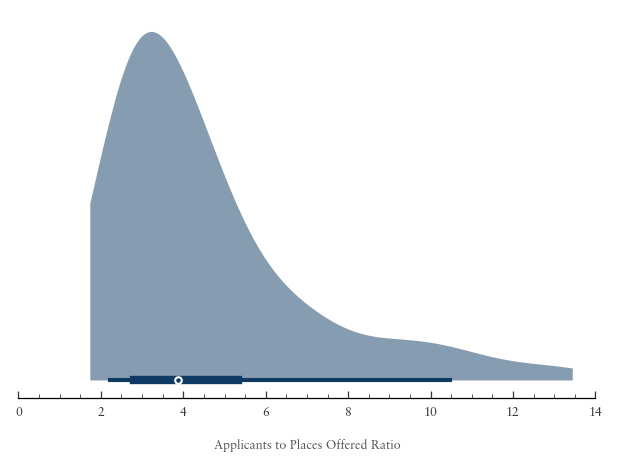

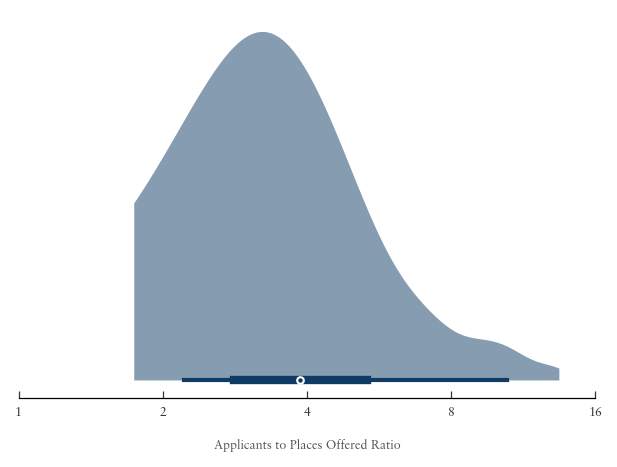

In [13]:
plot_dist(subset["ApplicationsPerAdmission"], title = "Applicants to Places Offered Ratio", clamp_range = True)
plt.xticks(np.arange(0, 15, 2))
plt.show()

plot_dist(subset["ApplicationsPerAdmission"], title = "Applicants to Places Offered Ratio", clamp_range = True)
plt.gca().set_xscale("log", base = 2)
plt.xticks(2**np.arange(0, 5, 1), 2**np.arange(0, 5, 1))
plt.show()

The ratio of applicants to admissions is seemingly log-normal though, which can wreak havoc on the validity of a linear model. 

Fortunately, the distribution can be transformed with the base-2 logarithm, which yields something in the shape of a gaussuan, (albeit with an unfortunate sharp lower limit at what corresponds to a 2.0 GPA).

We can then fit a linear model to model the relationship of the outcome variable (GPA cut-off) as a linear function of the logarithm of the applications-to-admissisions ratio. 

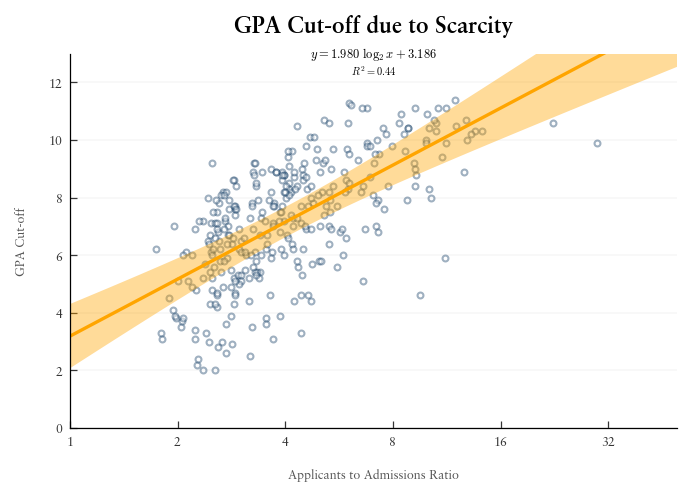

In [14]:
y = subset["GPACutOff"]
x = np.log2(subset["ApplicationsPerAdmission"])

plt.scatter(
    x,
    y, 
    s = 8,
    color = "C0",
    facecolor = "white",
    alpha = 0.4,
)

x_range = np.linspace(0, 6, dtype=float)
ticks = np.arange(0, 6, dtype=float)

params, cov = np.polyfit(x.tolist(), y.tolist(), deg = 1, cov = True)

predictions = np.polyval(params, x_range)
plt.plot(x_range, predictions, color = "orange")

slope_err, intercept_err = np.sqrt(np.diag(cov))
y_std = np.sqrt((predictions - y.mean())**2 * slope_err**2 + intercept_err**2)

plt.fill_between(
    x_range, 
    predictions - 1.96 * y_std, 
    predictions + 1.96 * y_std, 
    color="orange", 
    alpha=0.4, 
    edgecolor = "none"
)

plt.title("GPA Cut-off due to Scarcity")
plt.xlabel("Applicants to Admissions Ratio")
plt.ylabel("GPA Cut-off")
plt.ylim(0, 13)
# plt.gca().set_xscale("log", base = 2)
# plt.gca().set_yscale("log", base = 2)
plt.gca().set_xticks(ticks, [str(val).replace(".0", "") for val in 2**ticks])
plt.xlim(np.log2(1), np.log2(50))

plt.annotate(
    f"$y = {params[0]:.3f}\ \log_2 x + {params[1]:.3f}$",
    (0.5, 1),
    xycoords = "axes fraction",
    ha = "center",
    va = "center",
)

def r_squared(y, y_hat):
    ss_tot = ((y - y.mean())**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res / ss_tot)
plt.annotate(
    f"$R^2 = {r_squared(y, np.polyval(params, x)):.2f}$",
    (0.5, 0.955),
    size = 5,
    xycoords = "axes fraction",
    ha = "center",
    va = "center",
)

plt.margins(x = 0.01)
plt.show()

The model fit indicates that each time the applications-to-admissions ratio doubles, the expected GPA cut-off increases by 1.98. 

It's crucial to note, however, that such a relationship can only be claimed to hold in the range of observed inputs. The linear model, as it stands, does make predictions for an applicants-to-admissions ratio of e.g. 64, in which case the maximum likelihood estimate is greater than 12, the maximum achievable GPA (at least since Denmark ended the practice of incentivising enrolling at a university within two years of graduating high school by granting a GPA multiplication factor of 1.08 as well as rewarding elevated course load (during high school) with an added 1.06 multiplication factor).

A modest coefficient of determination ($R^2$) of 0.44 indicates that there is yet large amounts of unmodelled variance.

Looking at the model fit, a noticeable concern is that the linear relationship might be somewhat contrived in this case and that we should consider a function with a plateauing curve, e.g. a sigmoid, instead.

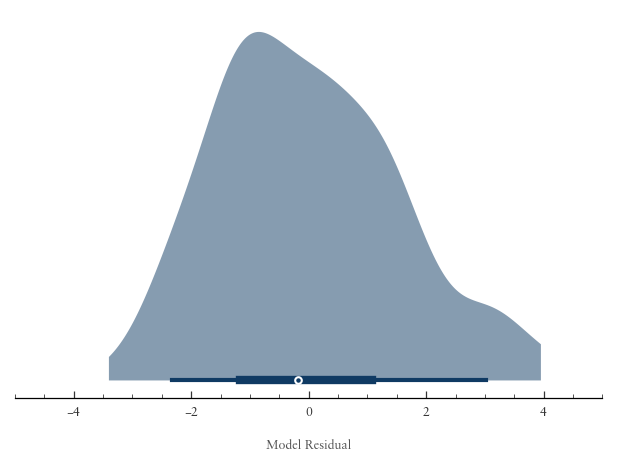

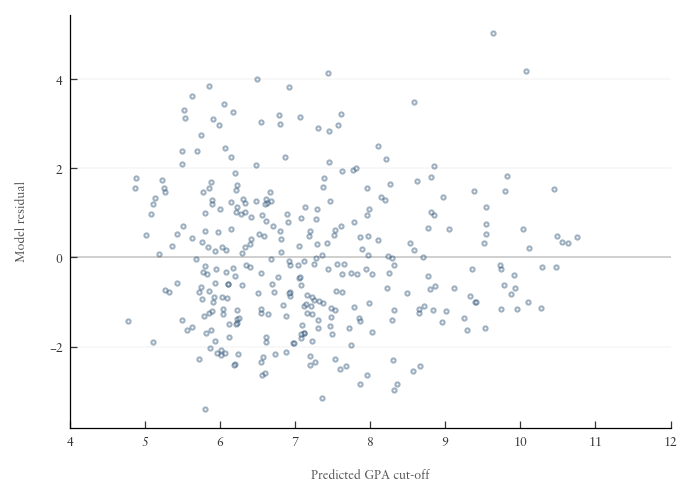

In [15]:
residuals = np.polyval(params, x) - y
predictions = np.polyval(params, x)

plot_dist(residuals, title = "Model Residual", clamp_range = True)
plt.xlim(-5, 5)
plt.show()

plt.figure()
plt.scatter(
    predictions,
    residuals, 
    s = 4,
    color = "C0",
    facecolor = "white",
    alpha = 0.4,
)
plt.xlabel("Predicted GPA cut-off")
plt.ylabel("Model residual")
plt.xlim(4, 12)
plt.axhline(0, color = "black", alpha = 0.2, linewidth = 0.8, zorder = -2)
plt.show()

The model residual (at least superficially) resembles a gaussian, satisfying the assumption of gaussian distribution of residuals. Homoscedasticity seems to be largely satisfied, with a couple of slightly worrying overestimations towards higher GPA cut-offs.